In [1]:
using Oceananigans
using Oceananigans.Models: ShallowWaterModel
using NCDatasets, Printf, CairoMakie

### Propagation of shallow water wave from initial disturbance

In [ ]:
f=5.e-5

Lx = 20e6
grid = RectilinearGrid(size = (256, 256),
                       x = (-Lx/2, Lx/2),
                       y = (-Lx/2, Lx/2),
                       topology = (Bounded, Bounded, Flat))

gravitational_acceleration = 9.81
coriolis = FPlane(f=f)

model = ShallowWaterModel(; grid, coriolis, gravitational_acceleration,
                          timestepper = :RungeKutta3,
                          momentum_advection = WENO())

η₀ = 1. #m
H = 100 #m
σ = 2e6 #m
x₀ = -Lx/2 + 2σ  #m
y₀ = -Lx/2 + 2σ  #m
hᵢ(x,y) = H + η₀*(sqrt((x-x₀)^2+(y-y₀)^2) < σ/2)*exp(-1/(1-((x-x₀)^2+(y-y₀)^2)/(σ/2)^2))/0.37
set!(model, h = hᵢ)


simulation = Simulation(model, Δt = 60, stop_time = 100*24*3600);

uh, vh, h = model.solution

fields_filename = joinpath(@__DIR__, string("../data/raw_simulation_output/shallow_water/shallow_water_2d_f=", coriolis.f, ".nc"))
simulation.output_writers[:fields] = NetCDFWriter(model, (; uh, vh, h),
                                                        filename = fields_filename,
                                                        schedule = TimeInterval(3600),
                                                        overwrite_existing = true)

run!(simulation)

┌ Warning: The ShallowWaterModel is currently unvalidated, subject to change, and should not be used for scientific research without adequate validation.
└ @ Oceananigans.Models.ShallowWaterModels ~/.julia/packages/Oceananigans/Rb6LJ/src/Models/ShallowWaterModels/shallow_water_model.jl:129
┌ Warning: Overwriting existing /Users/henrifdrake/code/ESS130/data/raw_simulation_output/shallow_water/shallow_water_2d_f=5.0e-5.nc.
└ @ OceananigansNCDatasetsExt ~/.julia/packages/Oceananigans/Rb6LJ/ext/OceananigansNCDatasetsExt.jl:1023
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (2.604 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (2.079 seconds).


In [46]:
ds = NCDataset(simulation.output_writers[:fields].filepath, "r")
close(ds)

closed Dataset

In [48]:
close(ds)

closed Dataset

In [31]:
close(ds)

closed Dataset

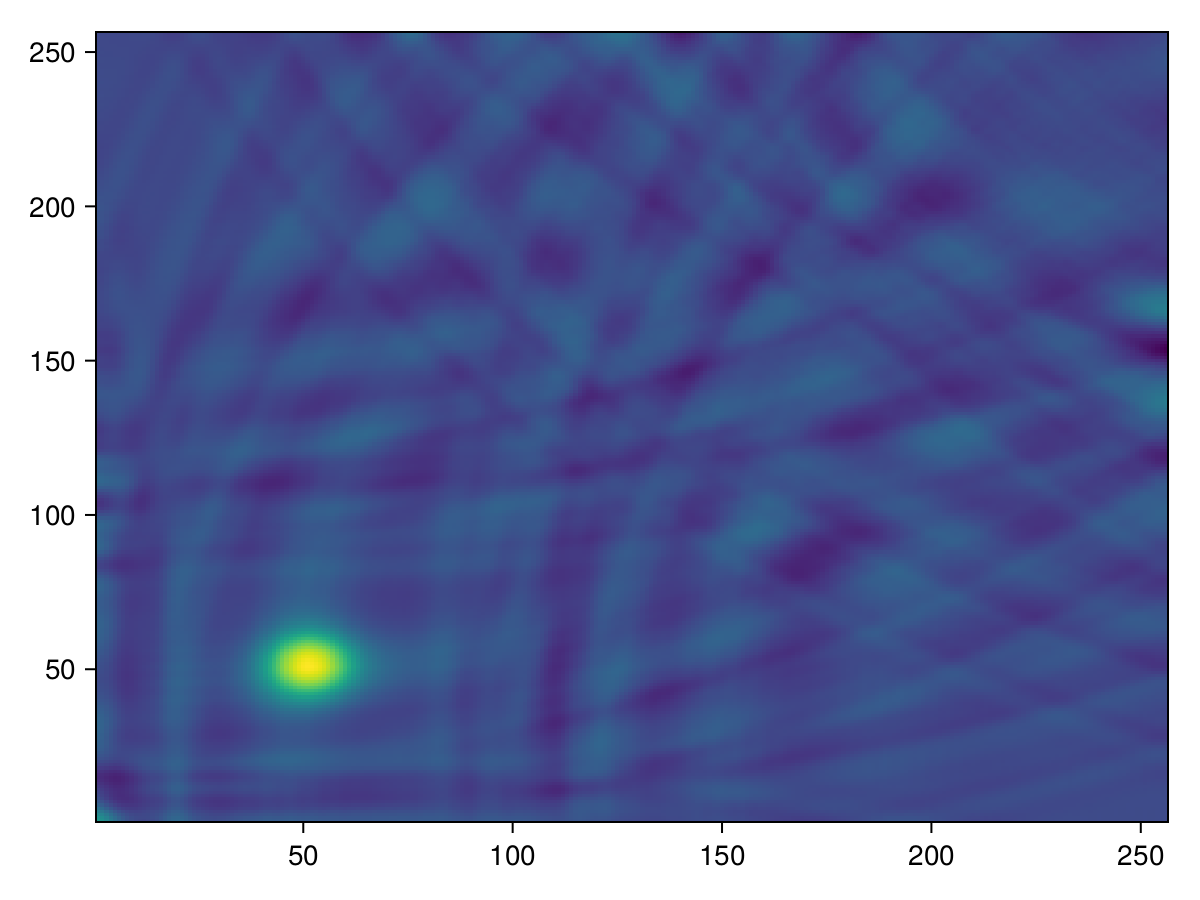

In [45]:
heatmap(ds["h"][:,:,1,350])

In [ ]:
ds = NCDataset(simulation.output_writers[:fields].filepath, "r")
x = ds["xC"];
times = ds["time"][:]
n = Observable(1)
η = @lift ds["h"][:, 1, 1, $n] .- H
v = @lift (ds["vh"][:, 1, 1, $n] ./ ds["h"][:, 1, 1, $n])

fig = Figure(size = (850, 550))

axis_kwargs = (xlabel = L"$x$ [km]", ylabel = L"$\eta(x,t)$ [m]", limits=((-Lx/2*1e-3, Lx/2*1e-3),(-0.3, η₀+0.3)))
ax_h  = Axis(fig[2, 1]; axis_kwargs...)
hm_h = lines!(ax_h, x*1e-3, η, linewidth=5, color=:black)
title = @lift @sprintf("t = %.1f", times[$n])
fig[1, 1] = Label(fig, title, fontsize=16, tellwidth=false)

axis_kwargs = (xlabel = L"$x$ [km]", ylabel = L"$v(x,t)$ [m/s]", limits=((-Lx/2*1e-3, Lx/2*1e-3),(-1, 1)))
ax_v  = Axis(fig[3, 1]; axis_kwargs...)
hm_v = lines!(ax_v, x*1e-3, v, linewidth=4)

resize_to_layout!(fig)

frames = 1:length(times)
record(fig, string("../movies/Lecture17_kelvin_waves_f=", coriolis.f, ".mp4"), frames, framerate=12) do i
    n[] = i
end

close(ds)
